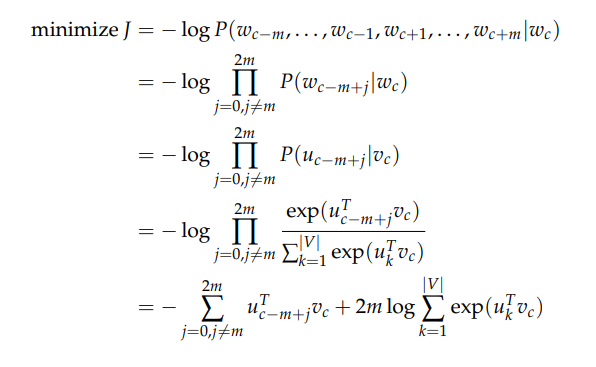

In [ ]:
import torch
import tqdm
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [ ]:
def prepare_sequence(seq, w2i):
    idxs = list(map(lambda w: w2i[w] if w2i.get(w) is not None else w2i["<unk>"], seq))
    return Variable(torch.LongTensor(idxs)).to(device)

def prepare_word(word, w2i):
    return Variable(torch.LongTensor([w2i[word]]) if w2i.get(word) is not None else torch.LongTensor([w2i["<unk>"]])).to(device)

In [ ]:
def get_batch(train_data, batch_size):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size

    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [ ]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:500]
corpus = [[word.lower() for word in sent] for sent in corpus]

In [ ]:
corpus[:2], len(corpus)

([['[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']'],
  ['etymology', '.']],
 500)

In [ ]:
word_count = Counter(flatten(corpus))
cutoff = int(len(word_count) * 0.01)
word_count.most_common()[:10], cutoff

([(',', 648),
  ('the', 533),
  ('.', 342),
  ('of', 299),
  ('a', 273),
  ('and', 258),
  ('in', 188),
  ('to', 182),
  ('--', 129),
  ('"', 120)],
 26)

In [ ]:
stop_words = word_count.most_common()[:cutoff] + list(reversed(word_count.most_common()))[:cutoff]
stop_words = [s[0] for s in stop_words]
stop_words[:10], len(stop_words)

([',', 'the', '.', 'of', 'a', 'and', 'in', 'to', '--', '"'], 52)

In [ ]:
vocab = list(set(flatten(corpus)) - set(stop_words))
vocab.append("<unk>")
vocab[:10], len(vocab)

(['feelings',
  'commerce',
  'rape',
  'probably',
  'pipe',
  'harpoon',
  'daniel',
  'supper',
  'abominable',
  'meanwhile'],
 2556)

In [ ]:
w2i = {"<unk>": 0}

for v in vocab:
    if w2i.get(v) == None:
        w2i[v] = len(w2i)

i2w = {v: k for k, v in w2i.items()}

In [ ]:
window_size = 3
windows_ = [list(nltk.ngrams(["<dummy>"] * window_size + c + ["<dummy>"] * window_size, window_size * 2 + 1)) for c in corpus]
windows = flatten(windows_)
windows[:10]

[('<dummy>', '<dummy>', '<dummy>', '[', 'moby', 'dick', 'by'),
 ('<dummy>', '<dummy>', '[', 'moby', 'dick', 'by', 'herman'),
 ('<dummy>', '[', 'moby', 'dick', 'by', 'herman', 'melville'),
 ('[', 'moby', 'dick', 'by', 'herman', 'melville', '1851'),
 ('moby', 'dick', 'by', 'herman', 'melville', '1851', ']'),
 ('dick', 'by', 'herman', 'melville', '1851', ']', '<dummy>'),
 ('by', 'herman', 'melville', '1851', ']', '<dummy>', '<dummy>'),
 ('herman', 'melville', '1851', ']', '<dummy>', '<dummy>', '<dummy>'),
 ('<dummy>', '<dummy>', '<dummy>', 'etymology', '.', '<dummy>', '<dummy>'),
 ('<dummy>', '<dummy>', 'etymology', '.', '<dummy>', '<dummy>', '<dummy>')]

In [ ]:
train_data = []

for window in windows:
    for i in range(window_size * 2 + 1):
        if i == window_size or window[i] == "<dummy>":
            continue
        train_data.append((window[window_size], window[i]))

In [ ]:
train_data[:20], len(train_data)

([('[', 'moby'),
  ('[', 'dick'),
  ('[', 'by'),
  ('moby', '['),
  ('moby', 'dick'),
  ('moby', 'by'),
  ('moby', 'herman'),
  ('dick', '['),
  ('dick', 'moby'),
  ('dick', 'by'),
  ('dick', 'herman'),
  ('dick', 'melville'),
  ('by', '['),
  ('by', 'moby'),
  ('by', 'dick'),
  ('by', 'herman'),
  ('by', 'melville'),
  ('by', '1851'),
  ('herman', 'moby'),
  ('herman', 'dick')],
 55758)

In [ ]:
X = []
y = []

for d in train_data:
    X.append(prepare_word(d[0], w2i).view(1, -1))
    y.append(prepare_word(d[1], w2i).view(1, -1))

train_data = list(zip(X, y))

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.V = nn.Embedding(vocab_size, embedding_size)
        self.U = nn.Embedding(vocab_size, embedding_size)

        self.V.weight.data.uniform_(-1, 1)
        self.U.weight.data.uniform_(0, 0) 

    def forward(self, center_words, target_words, outer_words):
        center_embeds = self.V(center_words)
        target_embeds = self.U(target_words)
        outer_embeds = self.U(outer_words)

        scores = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        norm_scores = outer_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        nll = - torch.mean(torch.log(torch.exp(scores) / torch.sum(torch.exp(norm_scores), 1).unsqueeze(1)))

        return nll

In [ ]:
epochs = 100
batch_size = 64
vocab_size = len(vocab)
embedding_size = 150
lr = 1e-3

In [ ]:
net = Net(vocab_size, embedding_size).to(device)
opt = torch.optim.Adam(net.parameters(), lr)

In [ ]:
def loop(net, batches):
    batch_losses = []
    net.train()

    for batch in batches:
        x, y = zip(*batch)

        x = torch.cat(x)
        y = torch.cat(y)
        z = prepare_sequence(list(vocab), w2i).expand(x.shape[0], len(vocab))

        loss = net(x, y, z)
        opt.zero_grad()
        loss.backward()
        opt.step()
        batch_losses.append(loss.item())

    return np.mean(batch_losses)

In [ ]:
for epoch in range(epochs):
    loss = loop(net, get_batch(train_data, batch_size))

    if epoch % 10 == 0:
        print(f"epoch: {epoch} | loss: {loss:.4f}")

epoch: 0 | loss: 6.3560
epoch: 10 | loss: 3.8091
epoch: 20 | loss: 3.6435
epoch: 30 | loss: 3.6101
epoch: 40 | loss: 3.6012
epoch: 50 | loss: 3.5962
epoch: 60 | loss: 3.5919
epoch: 70 | loss: 3.5893
epoch: 80 | loss: 3.5888
epoch: 90 | loss: 3.5859


In [ ]:
def get_similar_words(word, vocab):
    v_input = net.V(prepare_word(word, w2i))
    similar_words = []

    for i in range(len(vocab)):
        curr_word = vocab[i]
        if curr_word == word: continue

        v_curr = net.V(prepare_word(curr_word, w2i))
        cosine_sim = F.cosine_similarity(v_input, v_curr)
        similar_words.append([curr_word, cosine_sim.item()])

    return sorted(similar_words, key=lambda x: x[1], reverse=True)[:10]

In [ ]:
random_word = random.choice(vocab)
print(random_word)
get_similar_words(random_word, vocab)

expensive


[['lilies', 0.42819222807884216],
 ['isaiah', 0.4102192521095276],
 ['hval', 0.38594233989715576],
 ['invisible', 0.3836041986942291],
 ['lives', 0.3818894028663635],
 ['pool', 0.3746471107006073],
 ['peppered', 0.36951255798339844],
 ['<unk>', 0.3664342761039734],
 ['1846', 0.36607593297958374],
 ['weltering', 0.36384281516075134]]